In [26]:
%pylab inline
import sys
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
font = {'family' : 'sans-serif',
        'sans-serif': 'arial',
        'weight' : 'normal',
        'size'   : 9}

mpl.rc('font', **font)
mpl.rc('text', usetex=False)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


In [27]:
def jackknife( data_array ):
    from math import sqrt
    """ Return the jackknife standard deviation given a numpy array of samples. The formula is given by
        sig^2 = (N-1) sum_i ( ( mu_i - mu )^2 / N )
        where mu = 1/N sum data(i)
        and mu_i = 1/(N-1) ( ( sum_j data(j) ) - data(i) )
        see e.g.: http://www.physics.utah.edu/~detar/phycs6730/handouts/jackknife/jackknife/
    """
    N = len(data_array)
    m = data_array.mean()
    s = data_array.sum()
    sum = 0
    for i in range(N):
        mi = ( s - data_array[i] ) / (N - 1.)
        sum = sum + ( mi - m )**2 /float(N)

    sig2 = (N-1.) * sum

    return sqrt(sig2)

def bootstrap_ratio(data_list,nrepeats=300,nbins=2,bins_in=None,density=True):
    import numpy as np
    data_list = np.array(data_list)
    if bins_in is None:
        bins = nbins
    else:
        bins = bins_in
    hist,bins_total = np.histogram(data_list,bins=bins,density=density)
    nsamples = len(data_list)
    hist_list = []
    ratio_list = []
    for i in range(nrepeats):
        randidx = np.random.randint(0,nsamples,size=nsamples)
        new_data = data_list[randidx]
        hist,bins = np.histogram(new_data,density=density,bins=bins_total)
        hist_list.append(hist)
        ratio_list.append(hist[1]/hist[0])
    hist_array = np.array(ratio_list)
    hist_mean = np.mean(hist_array,axis=0)
    hist_std = np.std(hist_array,axis=0)
    return ba(bins_total), hist_mean, hist_std, bins_total

In [28]:
#define variables 
outdir = "figures/kinetic_competition_paper_pnas_draft"
!mkdir -p {outdir}

#nm
site_width = 37.
#actinin -fascin
dxl = 35.-8.

In [29]:
def f(x,Lp):
    Lp_sites = Lp*1e3/site_width
    return Lp_sites/x*(np.arcsin((dxl/site_width)/x)**2)

#A is the equilibrium ratio, kother/ksame
def ratio_at_dist(x,onleft,kon1,kon2,Lp):
    #0 on left
    #1 on left
    prefactor = (onleft==1)*kon2/kon1 + (onleft==2)*kon1/kon2
    return prefactor*exp(-f(x,Lp))

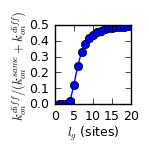

In [30]:
n_binding_sites = 20
binding_sites = np.arange(1,n_binding_sites+1,1.)
dist_ratio = ratio_at_dist(binding_sites,onleft=1,kon1=1,kon2=1,Lp=17)
p_switch = dist_ratio/(1+dist_ratio)

myfig = figure(figsize=(1.6,1.5))
plot(binding_sites,p_switch,marker='o')
ylabel("$k_{on}^{diff}/(k_{on}^{same}+k_{on}^{diff})$",labelpad=1)
xlabel('$l_g$ (sites)',labelpad=1)
xlim(0,20)
tight_layout()
savefig(os.path.join(outdir,'on_rate_ratio.pdf'), transparent='true')

Running until length reaches 15.000000 microns / 405 sites
('starting with type', 2)


(0.008130081300813009,
 0.0,
 array([ 6179.,  8880.]),
 array([2, 1]),
 array([  8.7041122 ,  12.98162582,   9.64871393,   5.99681001,
          1.74740293,   3.10159408,   5.40716681,  11.25645998,
         11.13752127,   3.28011242,  16.40760249,   1.0851075 ,
         14.86141855,  15.35980689,  10.18732165,   1.29702311,
          5.14674131,   5.34599681,  12.69180214,   2.29480556,
          9.2089738 ,   3.3454063 ,   7.88505095,  11.71798567,
          9.66245476,   6.52458262,   8.15742044,   0.6345075 ,
          4.65394327,   7.42024606,  12.08944834,   8.01664767,
          3.98344364,   3.63763031,   7.66217278,   6.55857467,
          9.84598112,   6.0377431 ,  13.24085322,   6.41227754,
          3.59418706,   8.04071919,  16.57791184,   2.26099155,
         13.79510542,  12.60108472,   9.78514095,  12.59857002,
          8.96168015,   3.98055486,  23.13539764,  10.59504165,
          9.71915839,  12.13814952,   6.01900699,  10.20175845,
          4.77099645,  12.1345689

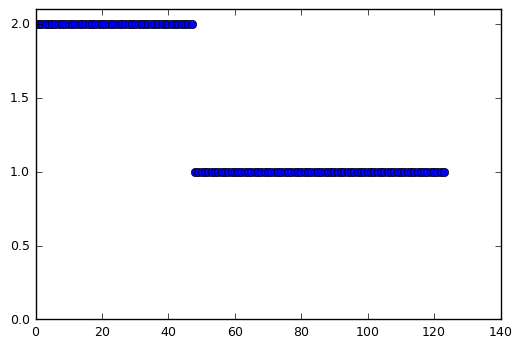

In [31]:
def rates(n_rate_sites,onleft,kon1,kon2,Lp):
    rate_list = []
    for i in range(1,n_rate_sites+1):
        p_diff = ratio_at_dist(i,onleft,kon1,kon2,Lp)
        if onleft==1:
            rate_list.append(kon1)
            rate_list.append(p_diff*kon1)
        elif onleft==2:
            rate_list.append(p_diff*kon2)
            rate_list.append(kon2)
        else:
            assert onleft in (1,2),"on_left is not either 1 or 2"
    return np.array(rate_list)

#extension rate is in nm/second
#max length in nm
def extension_population_ratio(num_trials=1,max_filament_length=15000,extension_rate=10, kon1=0.1,kon2=0.1, 
                               showplot=False,Lp=17,n_sites_init=1,max_extensions=50):
    
    site_extension_rate = float(extension_rate)/site_width
    assert extension_rate>0,"bundle has to be growing"
    max_n_sites = int(max_filament_length/site_width)
    print("Running until length reaches %f microns / %i sites"%(max_filament_length/1000,max_n_sites))

    # n_rate_sites is the distance out to which to compute a rate
    n_rate_sites = max_extensions+1
    
    #1 list for 1 on right, another for 2 on right
    rate_list = [rates(n_rate_sites,onleft=1,kon1=kon1,kon2=kon2,Lp=Lp), 
                rates(n_rate_sites,onleft=2,kon1=kon1,kon2=kon2,Lp=Lp)]
    
    prob_type_1 = kon1/(kon1+kon2)
    n_keep_list = np.zeros(num_trials)
    n_swap_list = np.zeros(num_trials)
    domain_length_list = []
    domain_type_list = []
    all_swap_list = []
    all_types_chosen = []

    
    nsites_needed = []
    times_chosen = []
    sites_chosen = []
    events_chosen = []
        
    for i in range(num_trials):
        current_site = 0
        filament_length = 0

        occupation_lattice = np.zeros(max_n_sites,dtype=int)
        current_type = 1+(np.random.random()>prob_type_1)
        occupation_lattice[current_site] = current_type
        
        if showplot: print("starting with type",current_type)
        t = 0
        
        
        filament_lengths = []
        swap_list = []
        types_chosen = []

        
        while(filament_length<max_filament_length):
            n_sites_away = n_sites_init
            filament_length += n_sites_away*site_width
            unbound = True
            prev_t = t
            
            while unbound and n_sites_away < max_extensions:
                tmp_rate_list = np.append(rate_list[current_type-1][:2*n_sites_away],site_extension_rate)
                #if t<100: print(tmp_rate_list)
                tmp_cum_rate = tmp_rate_list.cumsum()
                r1,r2 = np.random.random(size=2)
                event_chosen = np.searchsorted(tmp_cum_rate, r1*tmp_cum_rate[-1])
                t = t - np.log(r2)/tmp_cum_rate[-1]
                if event_chosen == len(tmp_rate_list)-1:  
                    n_sites_away += 1
                    filament_length += site_width
                else:
                    unbound = False
                assert n_sites_away < max_extensions, "error, max extensions reached"

            events_chosen.append(event_chosen)
            times_chosen.append(t-prev_t)
            nsites_needed.append(n_sites_away)
               
            sites_chosen.append((event_chosen//2)+1)
            types_chosen.append((event_chosen%2)+1)
            current_site += sites_chosen[-1]
            if current_site < len(occupation_lattice):
                occupation_lattice[current_site] = types_chosen[-1]
            swap_list.append(int(current_type!=types_chosen[-1]))
            current_type = types_chosen[-1]
            filament_lengths.append(filament_length)
        
        swap_array = np.array(swap_list)
        if np.sum(swap_array)>0:
            filament_length_at_swap_array = np.array(filament_lengths)[swap_array==1]
            #have to add in edge domains
            domain_lengths = np.insert( filament_length_at_swap_array[1:]-filament_length_at_swap_array[:-1],0,filament_length_at_swap_array[0])
            domain_lengths = np.insert( domain_lengths,len(domain_lengths),filament_lengths[-1]-filament_length_at_swap_array[-1])
            domain_types = np.insert( np.array(types_chosen)[swap_array==1], 0, occupation_lattice[0] )
        else:
            domain_lengths = [filament_length]
            domain_types = [occupation_lattice[0]]
        domain_length_list.extend(domain_lengths)
        domain_type_list.extend(domain_types)            
        
        if showplot is True:
            figure()
            plot(types_chosen,marker='o',linestyle='')
            ylim(0,2.1)
        n_keep_list[i]=(swap_array==0).sum()
        n_swap_list[i]=(swap_array==1).sum()
        all_swap_list.extend(swap_list)
        all_types_chosen.extend(types_chosen)


    swap_ratio = np.mean(n_swap_list/n_keep_list)
    swap_ratio_std = np.std(n_swap_list/n_keep_list)
    return swap_ratio,swap_ratio_std,np.array(domain_length_list),np.array(domain_type_list), \
               np.array(times_chosen),np.array(all_swap_list),np.array(sites_chosen)

extension_population_ratio(num_trials=1,kon1=0.05,kon2=0.05,extension_rate=10,showplot=True)

    

Running until length reaches 15.000000 microns / 405 sites


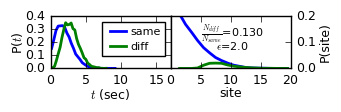

In [32]:
#bin average
def ba(bins):
    return (bins[1:]+bins[:-1])/2.0

#fig, ax = subplots(1,2,figsize=(3.5,1.2),sharey=True)

fig, ax = subplots(1,2,figsize=(3.5,1.2),sharey=False)

ratio, ratio_std, _,_, times_chosen, event_type_chosen, sites_chosen  = extension_population_ratio(num_trials=500,kon1=0.1,kon2=0.1,
                                                                            extension_rate=100,showplot=False)
num_trials = len(sites_chosen)

time_hist_same, time_bins_same = np.histogram(times_chosen[event_type_chosen==0],density=True,bins=30)
time_hist_diff, time_bins_diff = np.histogram(times_chosen[event_type_chosen==1],density=True,bins=30)


#plot(ba(time_bins),time_hist,c='k',label='times')
ax[0].plot(ba(time_bins_same),time_hist_same,label='same',lw=2)
ax[0].plot(ba(time_bins_diff),time_hist_diff,label='diff',lw=2)
ax[0].set_ylim(0,0.4)

ax[0].set_ylabel('P($t$)',labelpad=0)
ax[0].set_xlabel('$t$ (sec)',labelpad=0)
ax[0].set_xlim(0,17)
ax[0].set_xticks(np.arange(0,19,5))
ax[0].set_yticks(np.arange(0,0.45,.1))


ax[0].legend(loc=0,fontsize=8,handletextpad=0.1)

   
same_hist, same_bins = np.histogram( sites_chosen[event_type_chosen==0], density=False, bins=binding_sites )
diff_hist, diff_bins = np.histogram( sites_chosen[event_type_chosen==1], density=False, bins=binding_sites )

ax[1].plot(ba(same_bins), same_hist/float(num_trials), label='same',lw=2)
ax[1].plot(ba(diff_bins), diff_hist/float(num_trials), label='diff',lw=2)


ax[1].set_xlabel('site',labelpad=0)
ax[1].set_ylabel('P(site)',labelpad=2)

ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_ylim(0,0.2)

ax[1].set_yticks(np.arange(0,0.25,0.1))
ax[1].set_xticks(np.arange(0,25,5))

ax[1].annotate('$\\frac{N_{diff}}{N_{same}}$=%.3f'%ratio,xy=(5,0.12),fontsize=8)
ax[1].annotate('$\epsilon$=%.1f'%-log(ratio),xy=(7.5,0.07),fontsize=8)
tight_layout()
fig.subplots_adjust(hspace=0,wspace=0)

savefig(os.path.join(outdir,'example_pbind_mugrow100_kon0.1.pdf'),transparent='true')

Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites


/project/gavoth/glen842/software/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log


Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sit

(0, 0.1)

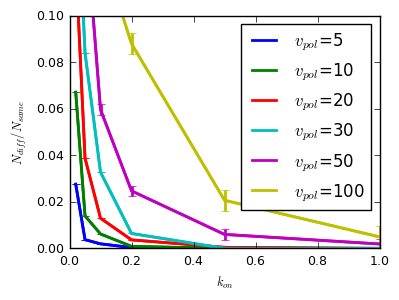

In [33]:
extension_rates = (5.0,10.,20.,30.,50.,100.)
kons = (0.02,0.05,0.1,0.2,0.5,1.0)
my_num_trials=10
all_energies = []
#all_times = []
figure(figsize=(4,3))
for extension_rate in extension_rates:
    ratios = []
    ratio_stds =[]
    energies = []
    #times = []
    for kon in kons:
        ratio, ratio_std,_,_,_,_,_ = extension_population_ratio(num_trials=my_num_trials,extension_rate=extension_rate,
                                                                   kon1=kon,kon2=kon)
        ratios.append(ratio)
        ratio_stds.append(ratio_std)
        energies.append(-np.log(ratio))
    myplt = plot(kons,ratios,lw=2,label="$v_{pol}$=%.f"%extension_rate)
    errorbar(kons,ratios,ratio_std,lw=2,c=myplt[0].get_c())

    all_energies.append(energies)

ylabel("$N_{diff}/N_{same}$")
xlabel('$k_{on}$')
legend(loc=0,fontsize=12)
ylim(0,0.1)

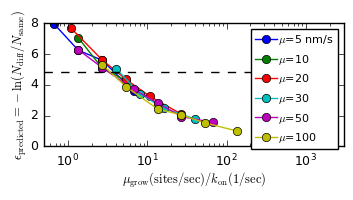

In [34]:
#also, think about what times mean here more
figure(figsize=(3.6,2))
#remember, v_pol in nm per second
for idx, extension_rate in enumerate(extension_rates):
    if idx == 0: 
        labelstring=" nm/s"
    else:
        labelstring=""
    plot(extension_rate/np.array(kons)/site_width, all_energies[idx],
         label="$\\mu$=%.f%s"%(extension_rate,labelstring),marker='o')


xlabel('$\\mu_\mathrm{grow} (\\mathrm{sites}/\\mathrm{sec}) /k_\\mathrm{on} {\\rm (1/sec)}$',labelpad=1)


legend(loc=0,fontsize=8,handletextpad=0.1,numpoints=1)
xscale('log')
xlim(0.5,3000)
yticks(np.arange(0,9,2))
ylabel('$\epsilon_{\\mathrm{predicted}}=-\mathrm{ln}(N_{\\rm diff}/N_{\\rm same})$',labelpad=1)
axhline(4.8,linestyle='--',color='k')
tight_layout()
savefig(os.path.join(outdir,'epsilon_collapse_voverk.pdf'), transparent='true')

In [ ]:
mymu = 40.
mykon2 = 0.26
my_num_trials=100

energies = []
avg_domain_lengths = [[],[]]
std_domain_lengths = [[],[]]

kratio_list = (0.3,0.5,1.0,1.5,2.0,2.5)

for kratio in kratio_list:
    ratio, ratio_std,domain_lengths,domain_types,_,_,_ = extension_population_ratio(num_trials=my_num_trials,
                                                                extension_rate=extension_rate,
                                                                kon1=mykon2*kratio,kon2=mykon2,max_filament_length=15000)
    avg_domain_lengths[0].append(domain_lengths[domain_types==1].mean())
    avg_domain_lengths[1].append(domain_lengths[domain_types==2].mean())
    std_domain_lengths[0].append(jackknife(domain_lengths[domain_types==1]))
    std_domain_lengths[1].append(jackknife(domain_lengths[domain_types==2]))
    energies.append(-np.log(ratio))

plt.figure()
plt.errorbar(kratio_list,np.array(avg_domain_lengths[0])/1e3,np.array(std_domain_lengths[0])/1e3,label="Type A",marker='o')
plt.errorbar(kratio_list,np.array(avg_domain_lengths[1])/1e3,np.array(std_domain_lengths[0])/1e3,label="Type B",marker='o')
xlim(0.1,2.75)
ylabel('domain length ($\mu$m)')
xlabel('[A]/[B]')
ylim(0,12)
legend(loc=0)

competition_prediction_data = np.array( (kratio_list, avg_domain_lengths[0],std_domain_lengths[0],avg_domain_lengths[1], std_domain_lengths[1]) ).T

savefig(os.path.join(outdir,'domain_size_mu40_kon0.26_finitelength.pdf'), transparent='true')
np.savetxt(os.path.join(outdir,'domain_size_mu40_kon0.26_finitelength.dat.txt'),competition_prediction_data )

Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites
Running until length reaches 15.000000 microns / 405 sites
